# Sentiment Analysis on Product Reviews

## Importing libraries

In [1]:
from pathlib import Path
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [2]:
SAVE_PLOTS = True
PLOT_DIR = Path("plots")
PLOT_DIR.mkdir(exist_ok=True)

def safe_filename(s : str) -> str:
    s = s.strip().lower() # Lowercase
    s = re.sub(r"\s+", "_", s) # turn sapces to underscore
    s = re.sub(r"[^a-z0-9._-]", "", s) # Remove any illegal characters
    return s

## Loading the IMDB 50k dataset

In [3]:
data_path = "data\IMDB_Dataset.csv"

df = pd.read_csv(data_path)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\vikra\AppData\Local\Temp\ipykernel_31696\869653858.py:1: SyntaxWarning: invalid escape sequence '\I'
  data_path = "data\IMDB_Dataset.csv"


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Checking the size, class balance, missing values

In [4]:
print("Rows, Columns : ", df.shape)
print("\nColumns : ", df.columns.tolist())

print("\nLabel distribuation :")
print(df["sentiment"].value_counts())

print("\nMissing values per column :")
print(df.isna().sum())

Rows, Columns :  (50000, 2)

Columns :  ['review', 'sentiment']

Label distribuation :
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing values per column :
review       0
sentiment    0
dtype: int64


## Cleaning the labels (0 = negative, 1 = positive)

In [5]:
# The model prefers numberic values, so we will convert/map
# "positive" -> 1, "negative" -> 0
label_map = {"positive" : 1, "negative" : 0}

# In our dataset there is no missing values, just in case the dataset changes in future
df = df.dropna(subset=["review", "sentiment"]).copy()

df["label"] = df["sentiment"].str.lower().map(label_map)
df[["sentiment", "label"]].head()

,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


## Text cleaner Function

In [6]:
def clean_text(text : str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"<[^>]+>", " ", text) # Remove HTML tags
    text = re.sub(r"http[s]?://\S+|www\.\S+", " ", text) # Remove URLs
    text = re.sub(r"[_\W]+", " ", text, flags=re.UNICODE) # Remove non-letters/digits
    text = re.sub(r"\s+", " ", text) # collapse multiple spaces
    return text.strip().lower() # Lowercase

## Splitting the data into training and testing data

In [7]:
X = df["review"].astype(str).tolist()
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) 

len(X_train), len(X_test)

(40000, 10000)

## Building the TF-IDF vectorizer

In [8]:
# We will make use of unigrams and bigrams, remove common English stop words, 
# and ignore too-rare terams and too-common terms to reduce the noise.
tf_idf = TfidfVectorizer(
    preprocessor=clean_text, # use clean_text() fn
    lowercase=True, 
    stop_words="english", # drop common funxtion words
    ngram_range=(1, 2), # unigram and bigrams 
    min_df=5, # Ignore terms that are seen in <5 reviews
    max_df=0.9 # Ignore terms in 90% reviews
)

## Logistic Regression and Multinomial Naive Bayes

In [9]:
# Logistic Regression
logreg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    random_state=42
)

# Multinomial Naive Bayes
mnb = MultinomialNB()

# We will create a Pipeline to avoid data leakage, Vectizer -> Classifier
logreg_pipe = Pipeline([
    ("tfidf", tf_idf),
    ("clf", logreg)
])

mnb_pipe = Pipeline([
    ("tfidf", tf_idf),
    ("clf", mnb)
])

## Training Logistic Regression and Multinomial Naive Bayes models

In [10]:
print("Training Logistic Regression...")
logreg_pipe.fit(X_train, y_train)

Training Logistic Regression...


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...00228DA1BCD60>
,tokenizer,None


In [11]:
print("Training Naive Bayes...")
mnb_pipe.fit(X_train, y_train)

Training Naive Bayes...


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...00228DA1BCD60>
,tokenizer,None


## Evaluating the models (accuracy, precision, recall, F1)

In [12]:
def evaluate(model_name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    print(f"\n-- {model_name} --")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1 : {f1:.4f}")
    print("\nClassification report : \n", classification_report(y_test, y_pred, digits=3))
    return y_pred

In [13]:
y_pred_lr = evaluate("Logistic Regression", logreg_pipe, X_test, y_test)


-- Logistic Regression --
Accuracy : 0.9008
Precision : 0.8928
Recall : 0.9110
F1 : 0.9018

Classification report : 
               precision    recall  f1-score   support

           0      0.909     0.891     0.900      5000
           1      0.893     0.911     0.902      5000

    accuracy                          0.901     10000
   macro avg      0.901     0.901     0.901     10000
weighted avg      0.901     0.901     0.901     10000



In [14]:
y_pred_mnb = evaluate("Multinomial Naive Bayes", mnb_pipe, X_test, y_test)


-- Multinomial Naive Bayes --
Accuracy : 0.8798
Precision : 0.8750
Recall : 0.8862
F1 : 0.8806

Classification report : 
               precision    recall  f1-score   support

           0      0.885     0.873     0.879      5000
           1      0.875     0.886     0.881      5000

    accuracy                          0.880     10000
   macro avg      0.880     0.880     0.880     10000
weighted avg      0.880     0.880     0.880     10000



## Plotting the confusion matrix

In [15]:
def plot_confusion(cm, title):
    plt.figure(figsize=(4, 4)) 
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()

    if SAVE_PLOTS:
        out_path = PLOT_DIR / f"{safe_filename(title)}.jpg"
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"Saved : {out_path}")

    plt.show()

In [16]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_mnb = confusion_matrix(y_test, y_pred_mnb)

Saved : plots\logistic_regression__confusion_matrix.jpg


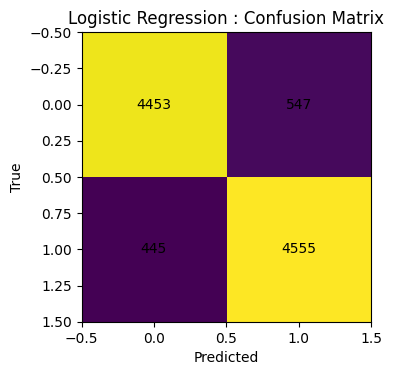

In [17]:
plot_confusion(cm_lr, "Logistic Regression : Confusion Matrix")

Saved : plots\naive_bayes__confusion_matrix.jpg


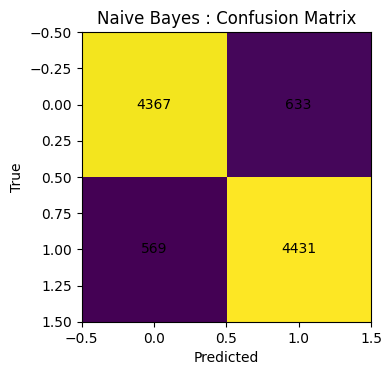

In [18]:
plot_confusion(cm_mnb, "Naive Bayes : Confusion Matrix")

## Showing the most positive and negative words (Logistic Regression)

In [19]:
# For Logistic Regresssion, each word / feature has a coefficient
# Positive cofficients push the prediction toward "positive", and negative towards "negative"

# Extracting trained vectoriser and classifier from the pipeline
tfidf_fitted = logreg_pipe.named_steps["tfidf"]
logreg_clf = logreg_pipe.named_steps["clf"]

feature_names = np.array(tfidf_fitted.get_feature_names_out())
coefs = logreg_clf.coef_[0]

# Top K positive and negative
top_K = 20
top_pos_idx = np.argsort(coefs)[-top_K:][::-1]
top_neg_idx = np.argsort(coefs)[:top_K]

In [20]:
def plot_top_terms(indices, values, title):
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), values, align="center")
    plt.yticks(range(len(indices)), feature_names[indices])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout()

    if SAVE_PLOTS:
        out_path = PLOT_DIR / f"{safe_filename(title)}.jpg"
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"Saved : {out_path}")
        
    plt.show()

Saved : plots\logreg__top_negative_terms_most_negative_coeficients.jpg


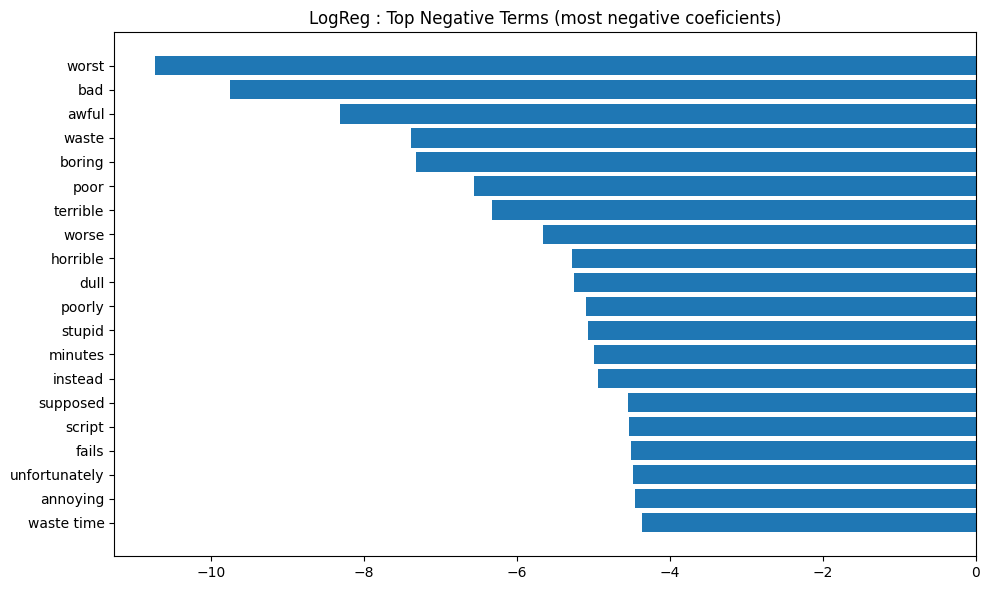

In [21]:
plot_top_terms(top_neg_idx, coefs[top_neg_idx], "LogReg : Top Negative Terms (most negative coeficients)")

Saved : plots\logreg__top_positive_terms_most_positive_coefficients.jpg


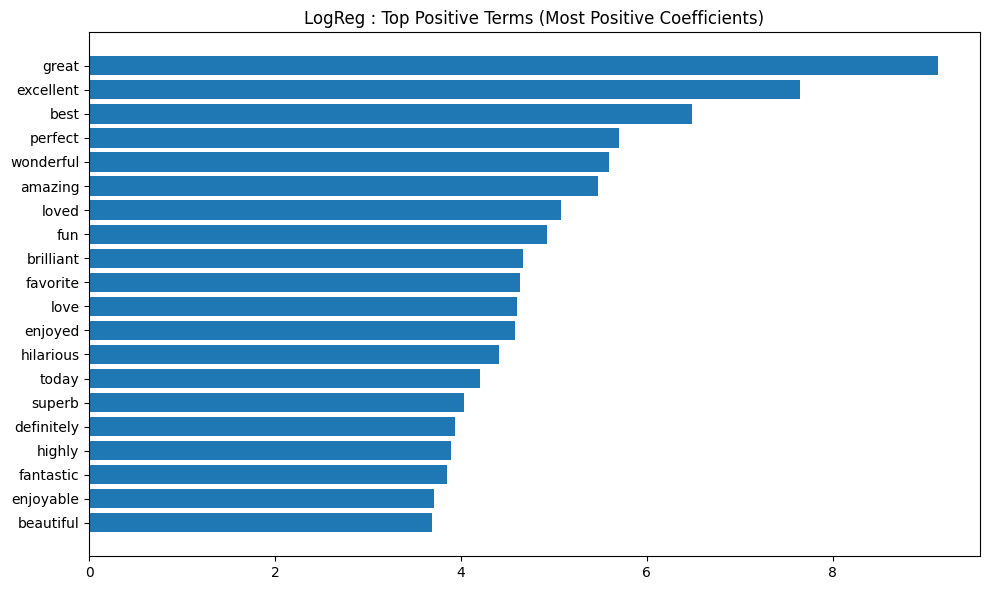

In [22]:
plot_top_terms(top_pos_idx, coefs[top_pos_idx], "LogReg : Top Positive Terms (Most Positive Coefficients)")

## Showing the most indicative words (Multinomial Naive Bayes)

In [23]:
# For MultinomialNB, feature_log_prob_ gives Log P(word | class)
# Words with higher log-prob in the postive class (vs nagative) are "positive learning", and vice cersa

tfidf_fitted_mnb = mnb_pipe.named_steps["tfidf"]
mnb_clf = mnb_pipe.named_steps["clf"]
feature_names_mnb = np.array(tfidf_fitted_mnb.get_feature_names_out())

log_prob = mnb_clf.feature_log_prob_ # shape : [2, vocab_size] -> [neg_class, pos_class]
diff = log_prob[1] - log_prob[0] # +ve minus -ve

top_k = 20
top_pos_idx_mnb = np.argsort(diff)[-top_k:][::-1]
top_neg_idx_mnb = np.argsort(diff)[:top_k]

Saved : plots\multinomial_naive_bayes__top_negative_terms_log_prob_diff.jpg


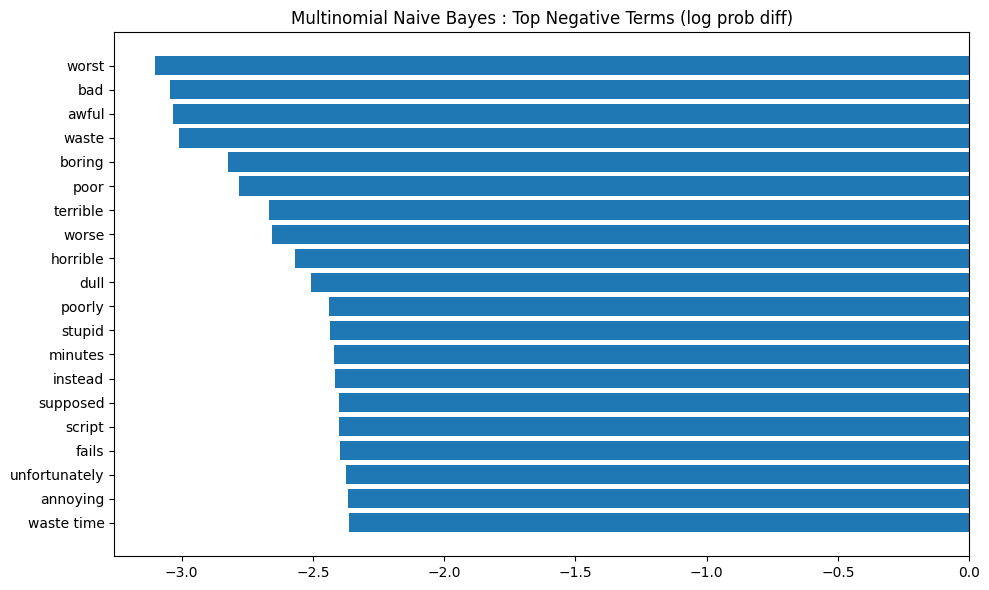

In [24]:
plot_top_terms(top_neg_idx, diff[top_neg_idx_mnb], "Multinomial Naive Bayes : Top Negative Terms (log prob diff)")

Saved : plots\multinomial_naive_bayes__top_positive_terms_log_prob_diff.jpg


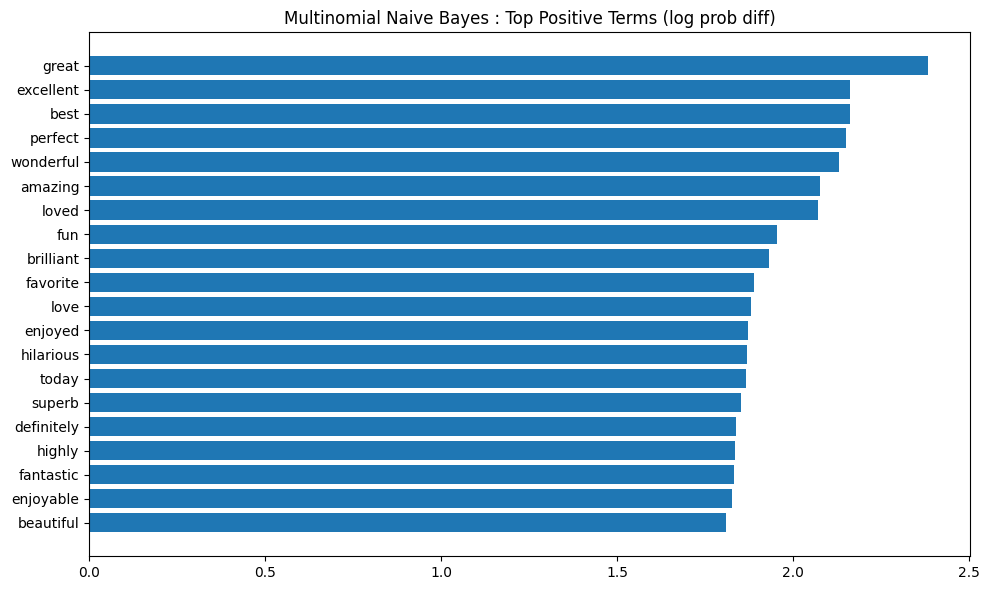

In [25]:
plot_top_terms(top_pos_idx, diff[top_pos_idx_mnb], "Multinomial Naive Bayes : Top Positive Terms (log prob diff)")